# Plummer sphere simulation
Group work.

In this experience we were tasked to simulate a Plummer sphere. This particular potential-density pair is a system at equilibrium, meaning we don't expect any collapse. 

The Plummer sphere is the spherical solution to the Lane-Emden equation, derived from the hypothesis of an equilibrium solution for a polytropic system. Which is a system that has the following equation of state

$$
    f(\varepsilon) = F \varepsilon^{n - 3/2} \qquad \text{with}\quad \varepsilon > 0
$$

where $F$ is a constant and $\varepsilon$ is the so called relative energy and it's defined as $\varepsilon = - E + \phi_0$ initial potential

### Notebook setup

In [1]:
import matplotlib
import numpy as np
import scipy
import random
import os
import time
import pandas as pd
import scipy.integrate as integrate
import scipy.special as special
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [2]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
%config InlineBackend.figure_format='retina'

In [3]:
N = 10**4
M = 1
b = 5
m = M/N
G = 1

# Initial positions

The Plummer sphere density profile is

$$
\rho \left( R \right) = \frac{3 M_{tot}}{4\pi b^3}\  \left(1 + \dfrac{r^2}{b^2}\right)^{-5/2}
$$

$\newline$

To initialize the Plummer sphere we need to set the correct distributions for our particles cartesian coordinates. To do so we first need to find the spherical coordinates and then project them onto the cartesian plane. 

The mass can be found by simple integration over the volume, which yields

$$
    M(r) = M_\text{tot}\ \dfrac{r^3}{b^3}\ \left(1 + \dfrac{r^2}{b^2}\right)^{-3/2}
$$
$\newline$

Inverting the relation for $\xi = M(r)/M_{tot}$ we obtain that 

$$
\begin{cases}
    \ R\ =\ b\ \sqrt{\left( \dfrac{ \xi^{2/3}}{1-\xi^{2/3}}\right)} && 0 \le \xi \le 1 \\ \\
    \ \varphi = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    \ \theta = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$

$\newline$

Now that we have the spherical coordinates we need to initialize their distribution, in this case a direct montecarlo takes care of it. We just initialize the cumulative and calculate the radii

In [4]:
r_cdf = np.random.uniform(0,1,N)
R = b * np.sqrt(r_cdf**(2/3)/(1- r_cdf**(2/3)))
theta_cdf = np.random.uniform(0,1,N)
theta = np.arccos(1 - 2 * theta_cdf)
phi = np.random.uniform(0, 2 * np.pi, size=N) 

0.0019056218673610622


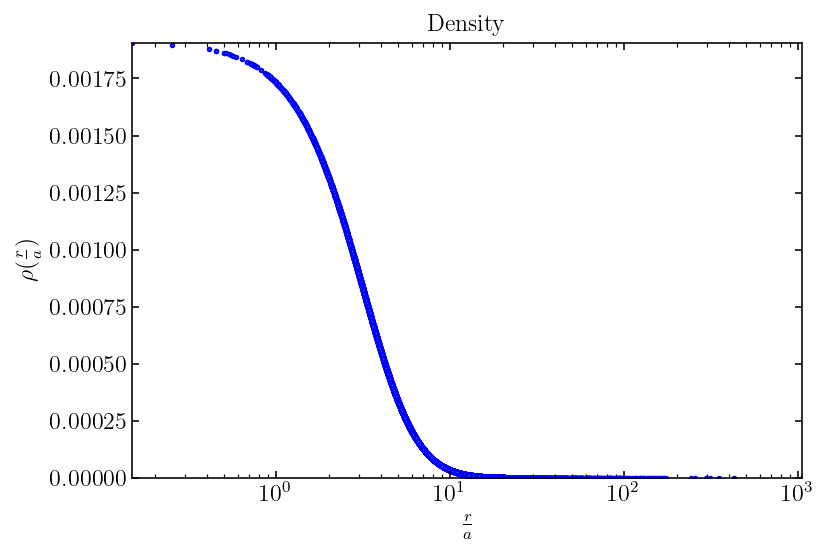

In [5]:
#Density
density = lambda m, a, r : ((3 * m) / (4 * np.pi * a**3) ) * (1 + (r/a) ** 2) ** (-2.5)

plotted = density(M, b, R)
print(np.max(plotted))
plt.scatter(R, plotted, s=3)
plt.xlabel(r'$\frac{r}{a}$')
plt.ylabel(r'$\rho(\frac{r}{a})$')
plt.title('Density')
plt.semilogx();

And then project them in the cartesian plane

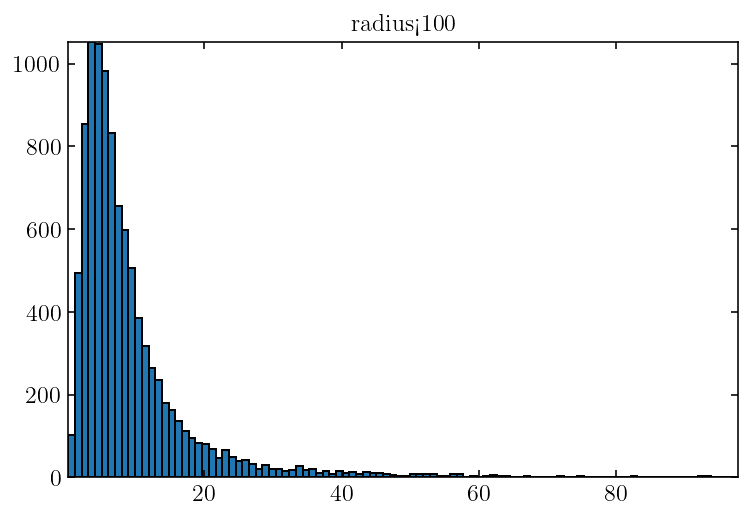

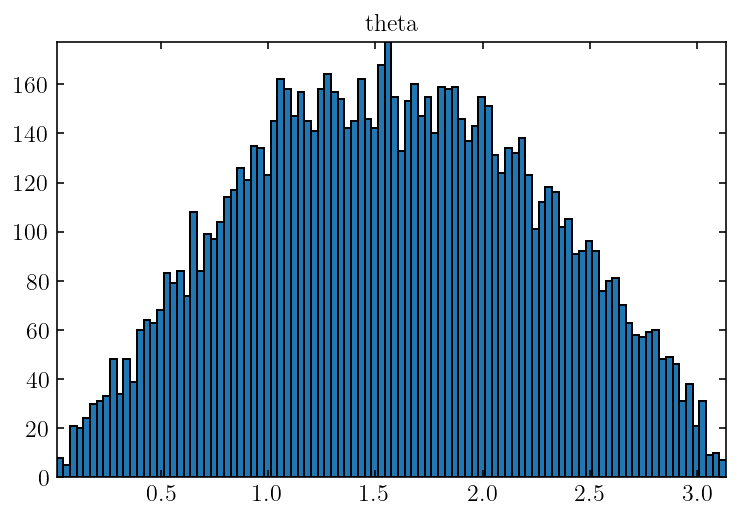

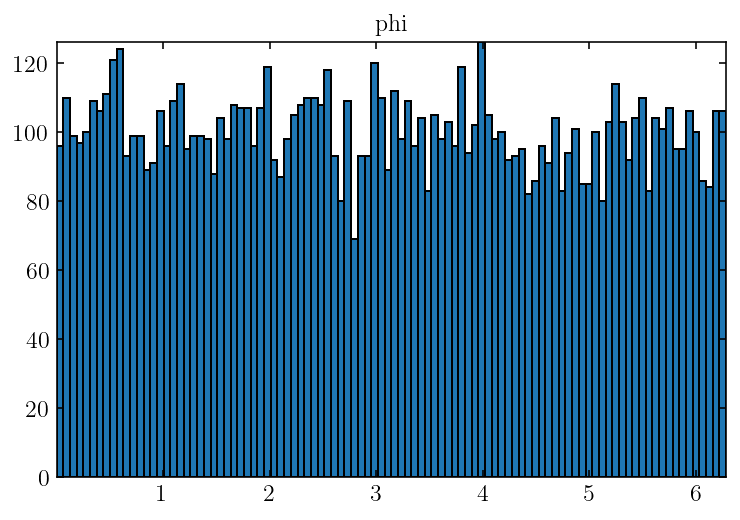

In [6]:
#Visualizing the distributions

plt.hist(R[R<100], bins=100);
plt.title('radius<100')
plt.show()
plt.hist(theta, bins=100);
plt.title('theta')
plt.show()
plt.hist(phi, bins=100);
plt.title('phi')
plt.show()

In [7]:
x = R * np.cos(phi) * np.sin(theta)
y = R * np.sin(phi) * np.sin(theta)
z = R * np.cos(theta)

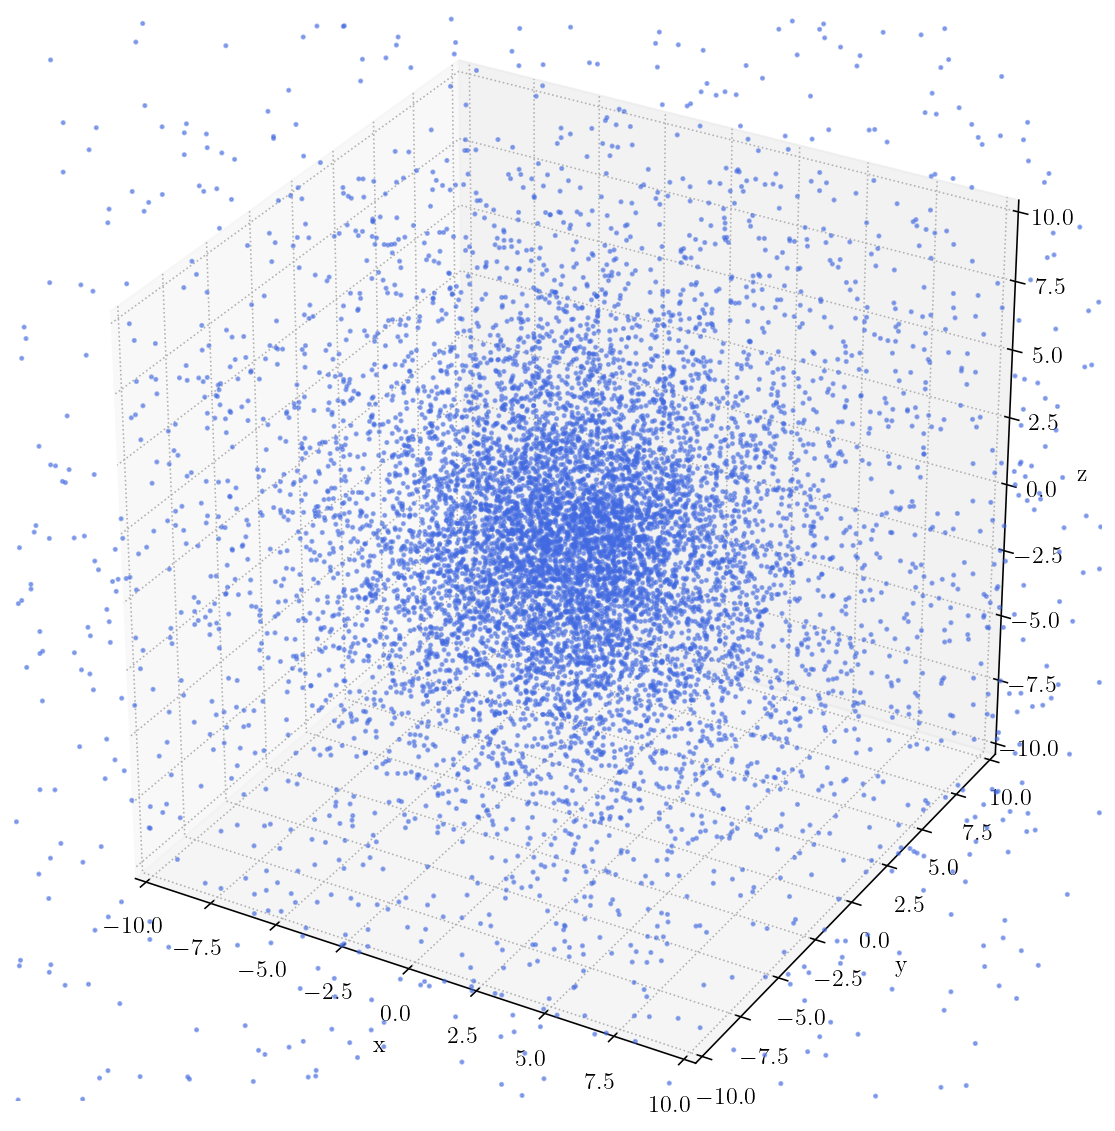

In [8]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection='3d')

ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
ax.scatter(x, y, z, color='royalblue', s=2.5 , alpha=.5)
#ax.set_aspect('auto')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

Finally we calculate the potential, which is simply 

$$
    \phi = - \dfrac{GM_\text{tot}}{\sqrt{r^2 + b^2}}
$$

But in the new formalism we will use the following quantity 

$$
    \psi = - \phi + \phi_0 = \dfrac{GM_\text{tot}}{\sqrt{r^2 + b^2}}
$$

In [9]:
Psi = G * M /(R**2 + b**2)**(1/2)

0.19991117219138446


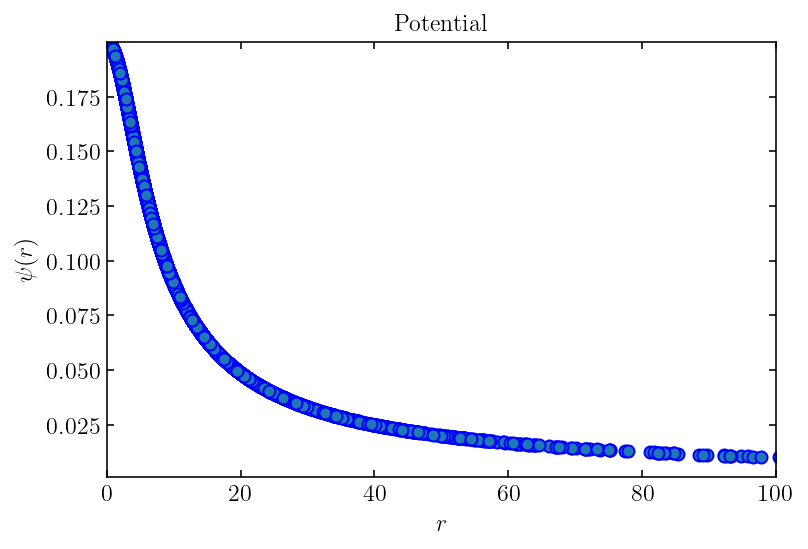

In [10]:
#Potential
potential = lambda m, r, a: - m / ((r**2 + a**2) ** 0.5)

psi = -potential(M, R, b)

print(np.max(psi))

plt.scatter(R, psi)
plt.xlim(0, 100)
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi(r)$')
plt.title('Potential');


# Initial velocities

The velocity distribution is isotropic. 

For bound orbits, the new formalism introduces an adimensional parameter $q$ which is simply the velocity of particles normalized to their escape velocity. If we want to calculate the velocity we need to flip this relation

$$
\vert \vec{v} \vert = q \sqrt{\psi}
$$
 
Now the $q$ distribution can be found by using the inverse of the cumulative. First let's caclulate the cdf, recalling that $\varepsilon = - E + \phi_0 = \psi - \frac{1}{2} v^2 $

$$
    F(\varepsilon) = \int_0^\varepsilon f(\varepsilon) \ d^3v = \int_0^\varepsilon dv\ 4\pi v^2 \ f(\varepsilon)
$$

And now one can extract the velocity from the definition of $\varepsilon$ simply by expressing the potential $\psi$ in terms of the velocity. After a few algebraic steps you find

$$
 F(q) = A \int_0^q q^2 \left(1-q^2\right)^{7/2}\ dq
$$

With $A$ normalization constant. Now that we have our cumulative our job would be to invert this relation analytically and then sample using inverse montecarlo, but this is really hard with this function. Plus we don't know the magnitude of the normalization constant. So we will use rejection method instead of inversion.

- Compute the normalization constant
- sample q with the Montecarlo rejection method
- Compute the magnitude of the velocities.  $\vert \vec{v} \vert = q \sqrt{\Psi}$
Since the distribution is isotropic, it should form a sphere in velocity space.

$\newline$

$$
\begin{cases}
   \vert \vec{v} \vert = q \sqrt{\Psi} &&  0 \le q \le 1  && \text{with rejection on $F(q)$} \\ \\
    v_{\varphi} = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    v_{\theta} = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$

$\newline$

And we simply project onto the cartresian plane.

$$
\begin{cases}
   v_{x} = \vert \vec{v} \vert \cos(v_{\varphi}) \sin(v_{\theta}) \\
   v_{y} = \vert \vec{v} \vert \sin(v_{\varphi}) \sin(v_{\theta}) \\
   v_{z} = \vert \vec{v} \vert  \cos(v_{\theta})
\end{cases}
$$

### Rejection method 101
We need to find a function $g(x)$ such that is larger than the pdf $f(x)$ for each $x$, this means we need to differentiate our $F(x)$ but this is very easy since we can just use the fundamental theorem of calculus and find

$$
    f(x) = A q^2 \ \left( 1 - q^2 \right)^{7/2}
$$

After we find a good choice for $g(x)$ we will compute the cumulative and the inverse of the cumulative to obtain some samples $y$ with inverse montecarlo method.
Then we accept only those $y$ such that $y < f(x)$

In [11]:
pdf_test = lambda x: (x**2*(1-x**2)**(3.5)) #our f(x)
A = integrate.quad(pdf_test,0,1)  #simple way to compute the normalization constant

q = np.linspace(0,1, int(1e6))     #our samples

pdf = 1/A[0]*(q**2*(1-q**2)**(3.5)) 
pdf_func = lambda x: 1/A[0]*(x**2*(1-x**2)**(3.5))
#the pdf obtained

g = np.ones(int(1e6))*np.max(pdf)  #the bigger function, just a constant line at the maximum of f(x)

Now we apply rejection, we sample N qs by extracting y from g and checking if it's low enough to be under f(x)

In [12]:
q_sample = []

for i in range(N):
    y_rand = np.max(g) + 1
    rand = np.random.uniform(0,1)
    while y_rand > pdf_func(rand):
        rand = np.random.uniform(0,1)
        y_rand = np.random.uniform(0,np.max(g))

    q_sample.append(rand)

q_sample = np.array(q_sample)

In [13]:
np.mean(q_sample)

0.4727912723625165

In [14]:
q_sample.shape

(10000,)

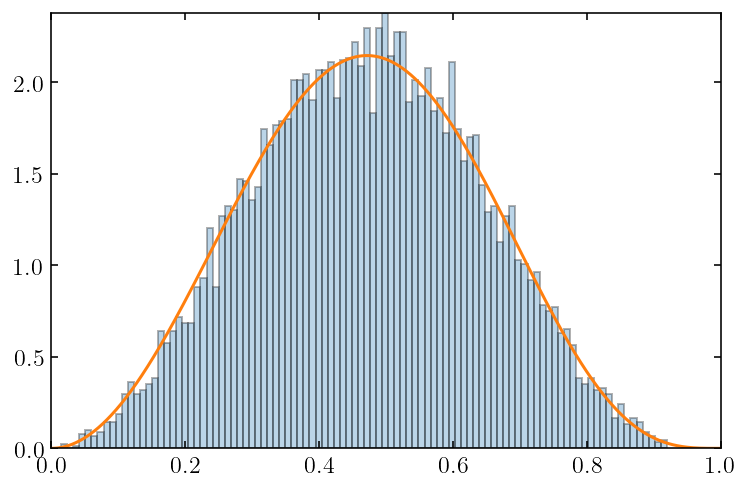

In [15]:

plt.hist(q_sample,100, density=True, alpha = .3)
plt.plot(q,pdf);

Now that we have our $q$ we can calculate the velocities in the spherical plane and then in the cartesian one

In [16]:
v = q_sample * np.sqrt(2 * Psi)
v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)
v_phi = np.random.uniform(0, 2 * np.pi, size=N) 
print(np.mean(v))

0.2235566151853045


In [17]:
v_x = v * np.cos(v_phi) * np.sin(v_theta)
v_y = v * np.sin(v_phi) * np.sin(v_theta)
v_z = v * np.cos(v_theta)

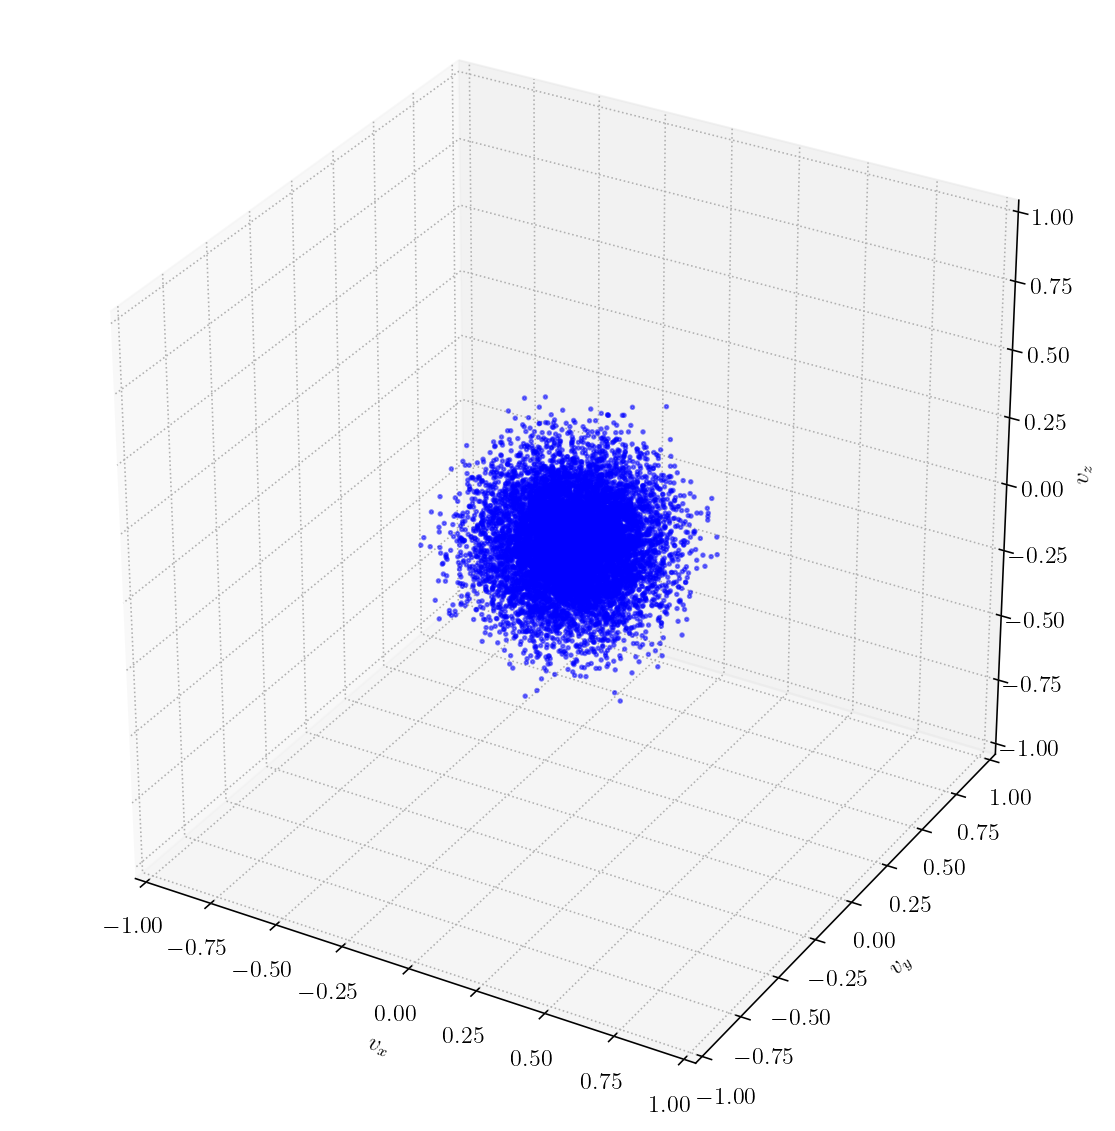

In [18]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection='3d')

ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.scatter(v_x, v_y, v_z, c = 'b', s=3, alpha = .5)
#ax.set_aspect('auto')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
plt.show();

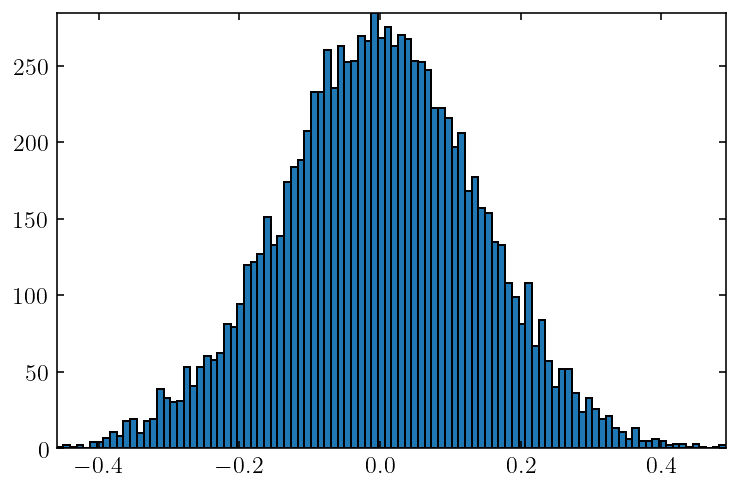

In [19]:
plt.hist(v_x,bins=100);

As expected we find our velocities spherically distributed in the phase space

# Initial condition file

Sourcing the correct path for running treecode

In [25]:
simulation = '/Users/oliverbenjaminrossi/Visual Studio/Università/Galaxies and Dynamics/Plummer Sphere/Tree-Code'
os.chdir(simulation)

Here we output everything to the initial condition file

In [26]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

# Parameter

Here we calculate the parameters to input to the executable

In [27]:
mask = R<b
V = 4/3 * np.pi * b**3
rho_ = np.sum(m_arr[mask])/ V
epsilon = 1/100 * (V/N)**(1/3)
T = np.sqrt((3 * np.pi) / (32 * G * rho_))

print('FreeFall time: {:.3f}'.format(T))
print('Dynamical time: {:.3f}'.format(3*T))

FreeFall time: 20.922
Dynamical time: 62.766


In [28]:
print(T)

20.92201764889729


In [29]:
T_sim = 3 * T
dt = 1/10
theta = 0.1
t_out = dt

print('Sim Time = {}\ndt = {}\nTheta = {}\nT output = {}'.format(T_sim, dt, theta, t_out))

Sim Time = 62.76605294669187
dt = 0.03125
Theta = 0.1
T output = 0.03125


In [30]:
import os
open('outdata_'+str(N)+'_'+str(theta)+'_'+str(dt)+'.txt', 'w').close()
T_sim = 10

os.system('./treecode in=in_data.txt  dtime='+ str(dt) +' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=outdata_'+str(N)+'_'+str(theta)+'_'+str(dt)+'.txt >logout.txt')
#os.system('time ./treecode in=in_data.txt  dtime='+ str(dt) +' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=outdata_'+str(N)+'_'+str(theta)+'_'+str(dt)+'.txt >logout.txt')


plummer_path = '/Users/oliverbenjaminrossi/Visual Studio/Università/Galaxies and Dynamics/Plummer Sphere'
os.chdir(plummer_path)

In [ ]:
#2minutes 7 seconds if it works for tsim = 10s